# Problema de Otimização do Transporte


Esse exercício utiliza dados da empresa de transporte fictícia  _"Trans-cegonha"_ para resolver um problema de otimização. O objetivo é encontrar a disposição ideal da frota de veículos da empresa, de maneira a maximizar o lucro, satisfazendo todas as restrições do problema.

O problema é apresentado com mais detalhes [aqui](transporte4.pdf).

## Modelagem

O processo de modelagem do problema é fundamental para a utilização de Algoritmos Genéticos, e uma boa modelagem certamente influenciará o resultado final, seja em sua qualidade ou no tempo necessário para obter uma solução satisfatória.

Para isso, precisa-se determinar o mapeamento "genótipo x fenótipo", bem como a função _fitness_, responsável por indicar quantitativamente a qualidade de um determinado indivíduo.

### Cromossomo

Cromossomo é a representação do problema no formato de um indivíduo que equivale à uma possível solução. Para este problema, escolheu-se usar 27 genes diferentes, cada um representando uma determinada rota e a quantidade de caminhões que foi ali alocada. O motivo dessa escolha foi o fato de que, apesar da quantidade de variáveis e restrições do problema, o resultado final é um reflexo direto da disposição inicial da frota de veículos.

Assim, cada indivíduo apresenta a distribuição da frota entre todas as possíveis rotas. A partir dessa informação, pode-se calcular todas as variáveis e considerar todas as restrições para avaliar o candidato à solução.

A representação dos genes é binária, e cada gene é representado por uma quantidade de bits diferente. A motivação dessa escolha foi restringir o espaço de busca, ao custo de adicionar um pouco de complexidade na representação. O valor máximo de cada gene foi calculado utilizando uma frota imaginária sem restrição de tamanho. Assim, chegou-se à quantidade ideal de caminhões por rota para atender a demanda. 

### Função objetivo

Como mencionado anteriormente, o exercício se trata de um problema de otimização. Mais especificamente, o objetivo é maximizar o lucro $L$ da empresa fictícia.

Cada caminhão pode operar por, no máximo, 24h por dia, ao longo de 30 dias do mês.

O lucro é obtido por:

$$L = R - C$$

A remuneração total $R$ se dá pelo somatório da remuneração indivídual mensal $r$ de cada um dos 68 caminhões que constituem a frota de veículos:

$$R = \sum_{i=1}^{68} r_i$$

A remuneração individual de cada veículo leva em consideração a quantidade de viagens $n$ feitas no mês e o pagamento $p$ (tabelado) de cada uma delas:

$$r_i = n_i \cdot p_i$$

A quantidade de viagens (ida e volta) pode depender do tamanho da demanda, limitando as viagens ao mês (introduzindo um tempo de ociosidade ao veículo durante o mês). Portanto, é preciso considerar o máximo de viagens que o caminhão pode fazer (com carregamento) $m$, e obter o minímo entre esse valor e o máximo de viagens de duração $t$ possível no mês:

$$n_i = min\bigg\{m_i, floor\bigg(\frac{30 \cdot 24}{t_i}\bigg)\bigg\}$$

A distância entre cada destino e origem possível é tabelada e fornecida, e o tempo de duração de cada viagem precisa levar em consideração o _overhead_ do tempo de carga e descarga:

$$t_i = ceil\bigg(\frac{d_i}{55}\bigg) + ceil\bigg(\frac{d_i}{75}\bigg) + 4$$
onde 55 é a velocidade média dos veículos (em km/h) na ida, e 75 na volta.

O custo total $C$ se dá pelo somatório do custo indivídual mensal $c$ de cada caminhão:

$$C = \sum_{i=1}^{68} c_i$$

O custo individual mensal de cada caminhão é obtido pelo produto entre a quantidade de viagens $n$ e o custo tabelado $\sigma$ de cada viagem:

$$c_i = n_i \cdot \sigma_i $$

A função objetivo nada mais é que o lucro normalizado para o intervalo $[0,1]$. Para isso, usou-se como valor teórico máximo o lucro para a frota teórica (mencionada anteriormente) de 103 caminhões:

$$\Omega = \frac{R - C}{12,532,255}$$

### Restrições

O problema conta com um número de restrições que devem ser levadas em consideração a fim de obter uma solução válida. São elas:

- Cada caminhão **sempre** transporta exatamente 11 veículos em cada viagem. Se esse requisito não for satisfeito, o caminhão não irá trafegar. (Essa restrição é aplicada no cálculo de viagens que o caminhão fará no mês)
- A frota de veículos é composta por 68 caminhões. Não se pode utilizar mais caminhões do que há disponível.
- Cada base de origem deve atender, pelo menos, dois destinos diferentes.
- A distribuição da frota deve atender, no mínimo, 72% da demanda de transporte.

Para quantificar e penalizar os indíviduos que não respeitarem essas restrições, as seguintes penalidades são aplicadas:

$$\hat h_1 = max\{0, \frac{Q - 68}{79}\}$$
onde 79 é o valor máximo de caminhões que podem ser alocados (na representação binária) além do limite permitido de 68, e $Q$ é a quantidade de caminhões utilizada.

$$\hat h_2 = max\{0, \frac{7 - B}{7}\}$$
onde $B$ é a quantidade de bases que atendem o requisito de fazerem entregas à, pelo menos, dois destinos diferentes.

$$\hat h_3 = max\{0, \frac{72 - D}{72}\}$$
onde $D$ é a porcentagem da demanda total atendida.

Todas as funções de restrição podem assumir somente valores dentro do intervalo $[0, 1]$.

### Função _fitness_

A função _fitness_, utilizada como métrica para quantificar a qualidade de uma solução, combina as funções objetivo e de penalidade apresentadas acima. Dessa forma, temos:

$$fitness = \frac{R - C}{12,532,255} - \frac{1}{1.5}\sum_{i=1}^{3}\hat h_i$$

O somatório das penalidades foi dividido por 1.5 (ao invés de 3) para aumentar o peso das penalidades durante o treinamento, pois nenhuma pode ser desrespeitada. No caso de a penalidade ser maior que o resultado da função _fitness_, atribui-se o valor 0.

## Implementação

A linguagem escolhida para a abordagem do problema foi Python, fazendo uso da implementação de Algoritmos Genéticos da biblioteca Inspyred.

Os dados de entrada foram fornecidos no formato de uma planilha. As células a seguir são responsáveis pela leitura da planilha e por sua manipulação para obter apenas os dados que são relevantes no momento.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
import csv

import inspyred
from inspyred.ec import terminators, selectors, observers, replacers

from time import time

# Read spreadsheet with data
sheet = pd.read_excel('planilha-transporte4.xls', sheet_name='Exercício com AG-2020')

Extração dos dados (matrizes) relevantes e armazenamento em objetos para fácil manipulação. As matrizes apresentadas a seguir trazem as bases de origem nas linhas, e as cidades de destino nas colunas.

Matriz de demandas:

In [2]:
# Filter spreadsheet to obtain the demand matrix
demand = sheet.iloc[3:11, 3:11]
demand = demand.rename(columns=demand.iloc[0], index=demand.iloc[:, 0]).iloc[1:, 1:]
demand.style.format("{:.0f}", na_rep="-")

,SAO,RIO,BSB,CNF,CWB,REC,POA
SCS,-,1701,1453,1072,975,384,-
SJP,1908,929,-,431,-,153,218
SBC,-,1245,-,-,547,-,304
BET,5246,-,1152,-,1118,407,-
DIA,-,1804,1452,-,-,-,703
PIR,-,-,-,307,325,109,156
PRL,509,-,-,100,111,-,-


Matriz de distâncias:

In [3]:
# Filter spreadsheet to obtain the distance matrix
dist = sheet.iloc[3:11, 14:22]
dist = dist.rename(columns=dist.iloc[0], index=dist.iloc[:, 0]).iloc[1:, 1:]
dist.style.format("{:.0f}", na_rep="-")

,SAO,RIO,BSB,CNF,CWB,REC,POA
SCS,-,448,1021,589,445,2709,-
SJP,413,853,-,1001,-,3058,728
SBC,-,465,-,-,434,-,1162
BET,554,-,746,-,962,2153,-
DIA,-,465,1027,-,-,-,1162
PIR,-,-,-,650,539,2745,1267
PRL,287,-,-,421,698,-,-


Matriz de custos:

In [4]:
# Filter spreadsheet to obtain the cost matrix
cost = sheet.iloc[15:23, 3:11]
cost = cost.rename(columns=cost.iloc[0], index=cost.iloc[:, 0]).iloc[1:, 1:]
cost.style.format("{:.0f}", na_rep="-")

,SAO,RIO,BSB,CNF,CWB,REC,POA
SCS,-,7667,22509,9902,7010,64803,-
SJP,5969,14539,-,16760,-,72317,12407
SBC,-,7739,-,-,6645,-,19279
BET,7570,-,15189,-,15068,42101,-
DIA,-,10619,29910,-,-,-,25711
PIR,-,-,-,11235,7110,49876,16910
PRL,3736,-,-,4699,6711,-,-


Matriz de remuneração:

In [5]:
# Filter spreadsheet to obtain the pay matrix
pay = sheet.iloc[15:23, 14:22]
pay = pay.rename(columns=pay.iloc[0], index=pay.iloc[:, 0]).iloc[1:, 1:]
pay.style.format("{:.0f}", na_rep="-")

,SAO,RIO,BSB,CNF,CWB,REC,POA
SCS,-,10703,24398,14069,10626,110813,-
SJP,11248,22101,-,25729,-,127278,19716
SBC,-,12606,-,-,11759,-,31504
BET,12188,-,21151,-,21164,53181,-
DIA,-,13854,27345,-,-,-,28820
PIR,-,-,-,22169,14300,86746,33548
PRL,7356,-,-,11754,18326,-,-


Matriz de lucro por viagem completa:

In [6]:
profit = pay - cost
profit.style.format("{:.0f}", na_rep="-")

,SAO,RIO,BSB,CNF,CWB,REC,POA
SCS,-,3036,1889,4167,3616,46010,-
SJP,5279,7562,-,8969,-,54961,7309
SBC,-,4867,-,-,5114,-,12225
BET,4618,-,5962,-,6096,11080,-
DIA,-,3235,-2565,-,-,-,3109
PIR,-,-,-,10934,7190,36870,16638
PRL,3620,-,-,7055,11615,-,-


Para definir o tamanho ideal da frota, utilizou-se as matrizes acima para calcular a quantidade caminhões necessária para melhor atender a demanda. Nesta célula também são calculados alguns valores que serão utilizados novamente no futuro, para economizar processamento.

In [7]:
# Time per complete trip per route
t = (np.ceil((dist / 55).replace(np.nan, 0)) + np.ceil((dist / 75).replace(np.nan, 0)) + 4).replace(4, np.nan)
# Maximum number of monthly trips per route considering only time limits
max_t = np.floor((30 * 24) / t)
# Maximum number of monthly trips per route considering only demand limits
max_d = demand // 11
# Qty of allowed trips considering demand AND time limits. This is the real value to be used
max_r = max_d.where(max_d < max_t, max_t)
# Number of vehicles needed to satisfy as much of the demand as possible
ideal = np.ceil((demand.replace(np.nan, 0) // 11) / max_r.replace(np.nan, 0))
print("Disposição ideal calculada:")
display(ideal.style.format("{:.0f}", na_rep="-"))
# Used later to obtain the DataFrame representation of an individual
mask = ideal > 0
print("Tamanho da frota calculada: ", ideal.sum().sum().astype(int))

Disposição ideal calculada:


,SAO,RIO,BSB,CNF,CWB,REC,POA
SCS,-,5,7,4,3,5,-
SJP,5,4,-,3,-,2,1
SBC,-,4,-,-,2,-,2
BET,16,-,5,-,6,5,-
DIA,-,5,7,-,-,-,4
PIR,-,-,-,1,1,2,1
PRL,1,-,-,1,1,-,-


Tamanho da frota calculada:  103


Para poder diferenciar os genes dentro da representação binária, precisamos saber onde cada um começa e termina. Essa informação é obtida com a função a seguir, partindo da representação ideal calculada anteriormente.

In [8]:
def bin_rep_idx(values):
    i = 0
    indices = []
    for v in values:
        l = len(bin(v)) - 2
        indices.append(l + i)
        i = i + l
    
    print("Bits necessários para a representação binária:", indices[-1])
        
    return indices[:-1], indices[-1]

In [9]:
# Indices of genes within the binary representation of an individual
ideal_int = ideal.replace(np.nan, 0).astype(int)
idx, n_bits = bin_rep_idx(ideal_int.to_numpy()[ideal_int.to_numpy() > 0])

Bits necessários para a representação binária: 63


A partir daqui, começa a ser desenvolvido o código necessário para rodar o Algoritmo Genético.

Primeiro, definimos a função responsável por gerar indivíduos aleatóriamente:

In [10]:
# Generates random individuals
@inspyred.ec.generators.diversify
def generate(random, args):
    n_bits = args.get('n_bits')
    
    return [np.random.choice([0, 1]) for i in range(n_bits)]

Aqui nós temos a função responsável por calcular o fitness de um determinado indivíduo:

In [11]:
# Calculates fitness in order to evaluate a solution candidate
@inspyred.ec.evaluators.evaluator
def evaluate(candidate, args):
    max_t = args.get('max_t')
    max_d = args.get('max_d')
    profit = args.get('profit')
    demand = args.get('demand')
    mask = args.get('mask')
    idx = args.get('idx')
    
    df = df_rep(candidate, mask, idx)
    total = (df * max_t)
    total = total.where(total < max_d, max_d)
    
    obj = (total * profit).sum().sum()
    obj = obj / 12532255
    
    # Return calculated fitness. If the penalty is higher than the obj value, we set the fitness to zero in order to avoid negative values
    return max(0, obj - penalty(df, demand, total))

Para melhor organização do código, a penalidade é calculada na função a seguir:

In [12]:
# Calculates and returns penalties
def penalty(candidate_df, demand, total):
    q = candidate_df.sum().sum()
    h1 = max(0, (q - 68) / 79)
    
    b = candidate_df.replace(np.nan, 0).astype(bool).sum(axis=1)
    h2 = max(0, (7 - b[b >= 2].count()) / 7)
    
    d = total.sum().sum() * 100 / (demand / 11).sum().sum()
    h3 = max(0, (72 - d) / 72) 
    
    return (h1 + h2 + h3) / 1.5

Essa função é responsável por transformar a representação binária do indivíduo em um objeto `DataFrame` mais fácil de ser trabalhado e interpretado.

In [13]:
# This function decodes the binary representation of a given individual and returns a DataFrame
def df_rep(candidate, mask, idx):
    genes = np.split(candidate, idx)
    int_rep = []
    
    for g in genes:
        int_rep.append(int("".join([str(bit) for bit in g]), 2))
    
    df = ideal.copy().replace(0, np.nan)
    df.iloc[mask] = int_rep
    
    return df

`plot()` recebe o índice de um arquivo de log e plota o gráfico de fitness para o melhor e o pior indíviduo de cada geração, bem como a média da métrica.

In [14]:
# Plot fitness graph
def plot(index):
    csvfile = open(f"inspyred-statistics-file-{index}.csv")
    reader = csv.reader(csvfile, delimiter=',')

    best_stats = []
    worst_stats = []
    avg_stats = []
    generations = []

    for row in reader:
        generations.append(int(row[0]))
        worst_stats.append(float(row[2]))
        best_stats.append(float(row[3]))
        avg_stats.append(float(row[4]))

    plt.figure(dpi=100)
    plt.plot(generations, best_stats, 'g', label='best')
    plt.plot(generations, avg_stats, 'b', label='average')
    plt.plot(generations, worst_stats, 'r', label='worst')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()

    plt.show()

Aqui o objeto que representa o AG é criado e todos seus parâmetros configurados. A função `main()` retorna o indivíduo com maior valor de _fitness_ depois que o processo de evolução chega ao fim.

In [15]:
# Genetic Algorithm declaration
def main(i):
    rand = random.Random()
    rand.seed(int(time()))
    
    f_stats = open(f"inspyred-statistics-file-{i}.csv", 'w')
    f_indv = open(f"inspyred-individuals-file-{i}.csv", 'w')
    
    pop_size = 150

    ga = inspyred.ec.GA(rand)
    ga.observer = observers.file_observer
    ga.terminator = terminators.generation_termination
    ga.selector = selectors.tournament_selection
    ga.replacer = replacers.generational_replacement 

    final_pop = ga.evolve(generator=generate,
                          evaluator=evaluate,
                          statistics_file=f_stats,
                          individuals_file=f_indv,
                          tournament_size=3,
                          max_generations=300,
                          crossover_rate=0.5,
                          mutation_rate=0.02,
                          num_crossover_points=2,
                          pop_size=pop_size,
                          num_elites=1,
                          n_bits=n_bits,
                          max_t=max_t,
                          max_d=max_d,
                          profit=profit,
                          demand=demand,
                          mask=mask,
                          idx=idx)

    return max(final_pop)

Repete o processo de evolução `repeat` vezes e plota o gráfico da melhor rodada.

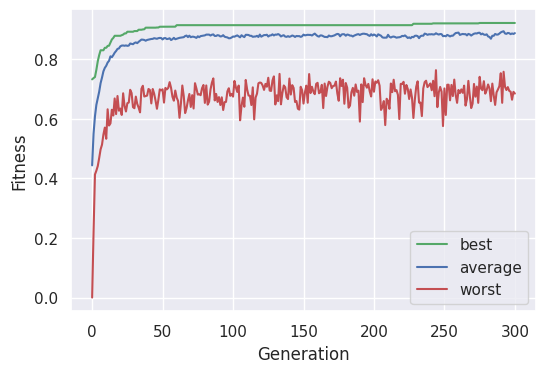

In [16]:
repeat = 10
best_l = []
    
for i in range(repeat):
    best = main(i)
    best_l.append(best)
        
best = max(best_l)
index = best_l.index(best)
plot(index)

Interpretação do resultado final obtido:

In [17]:
df = df_rep(best.candidate, mask, idx)
total = df * max_t
total = total.where(total < max_d, max_d)
print(f"Cobertura da demanda total: \t\t{total.sum().sum() * 100 / (demand / 11).sum().sum():.2f}%")
print(f"Lucro total: \t\t\t\t{int((total * profit).sum().sum()):,}")
print(f"Quantidade de caminhões utilizados: \t{df.sum().sum().astype(int)}")
print(f"Fitness do candidato final: \t\t{best.fitness:.5f}")
print(f"Penalidade aplicada ao candidato final: {penalty(df, demand, total):.5f}")
print("\nDisposição dos caminhões:\n")
display(df.style.format("{:.0f}", na_rep="-"))
print("\nVeículos transportados por mês:")
display((total * 11).style.format("{:.0f}", na_rep="-"))
print("\nAtendimento da demanda mensal:")
display((total / (demand / 11)).style.format("{:.2%}", na_rep="-"))

Cobertura da demanda total: 		79.64%
Lucro total: 				11,552,371
Quantidade de caminhões utilizados: 	68
Fitness do candidato final: 		0.92181
Penalidade aplicada ao candidato final: 0.00000

Disposição dos caminhões:



,SAO,RIO,BSB,CNF,CWB,REC,POA
SCS,-,4,0,3,2,5,-
SJP,4,4,-,2,-,2,1
SBC,-,3,-,-,1,-,2
BET,15,-,4,-,5,0,-
DIA,-,4,0,-,-,-,1
PIR,-,-,-,1,1,1,1
PRL,1,-,-,0,1,-,-



Veículos transportados por mês:


,SAO,RIO,BSB,CNF,CWB,REC,POA
SCS,-,1628,0,1023,814,374,-
SJP,1760,924,-,418,-,143,209
SBC,-,1188,-,-,440,-,297
BET,5115,-,1100,-,1100,0,-
DIA,-,1584,0,-,-,-,187
PIR,-,-,-,297,319,77,154
PRL,506,-,-,0,110,-,-



Atendimento da demanda mensal:


,SAO,RIO,BSB,CNF,CWB,REC,POA
SCS,-,95.71%,0.00%,95.43%,83.49%,97.40%,-
SJP,92.24%,99.46%,-,96.98%,-,93.46%,95.87%
SBC,-,95.42%,-,-,80.44%,-,97.70%
BET,97.50%,-,95.49%,-,98.39%,0.00%,-
DIA,-,87.80%,0.00%,-,-,-,26.60%
PIR,-,-,-,96.74%,98.15%,70.64%,98.72%
PRL,99.41%,-,-,0.00%,99.10%,-,-
